**Evolutionary Computing Implementation**



**Function Minimization** - Uses the evolutionary algorithm to find the minimum of the Rosenbrock function, a common benchmark in optimization algorithms.
**Traveling Salesman Problem (TSP)** - Demonstrates how to apply evolutionary algorithms to combinatorial optimization by finding the shortest path connecting multiple cities.
**Portfolio Optimization** - Shows a real-world financial application where the algorithm maximizes the Sharpe ratio (return-to-risk ratio) for an investment portfolio.

The implementation includes all the key components of evolutionary algorithms:

**Representation**: Individuals are represented as real-valued vectors
**Selection**: Tournament selection to choose parents for reproduction
**Crossover**: Uniform crossover to combine genetic material from parents
**Mutation**: Gaussian mutation to introduce diversity
**Elitism**: Preservation of the best solutions to ensure progress

Minimizing Rosenbrock Function:
Best solution found: [0.90633973 0.82192113]
Fitness value: 0.008794282418523187
Expected optimum: [1.0, 1.0] with value 0.0


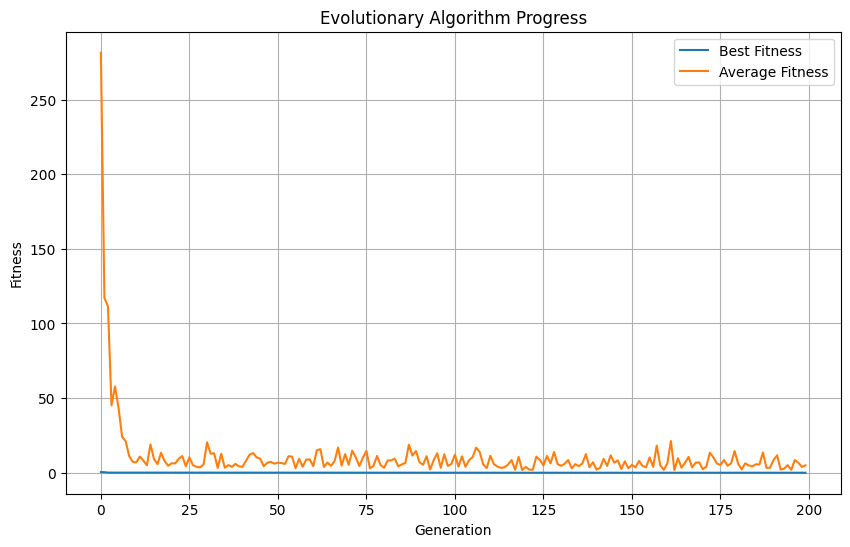

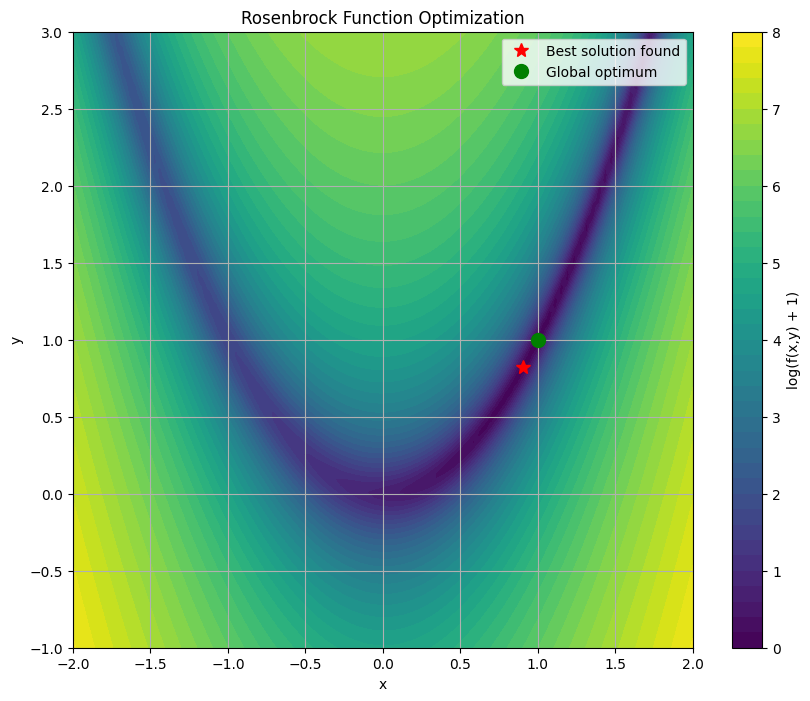


Traveling Salesman Problem:
Best route found: [16  5  3 13  8 19  6 15 10 14 18  2  7 11  9  1 17  4 12  0]
Total distance: 430.2017254683683


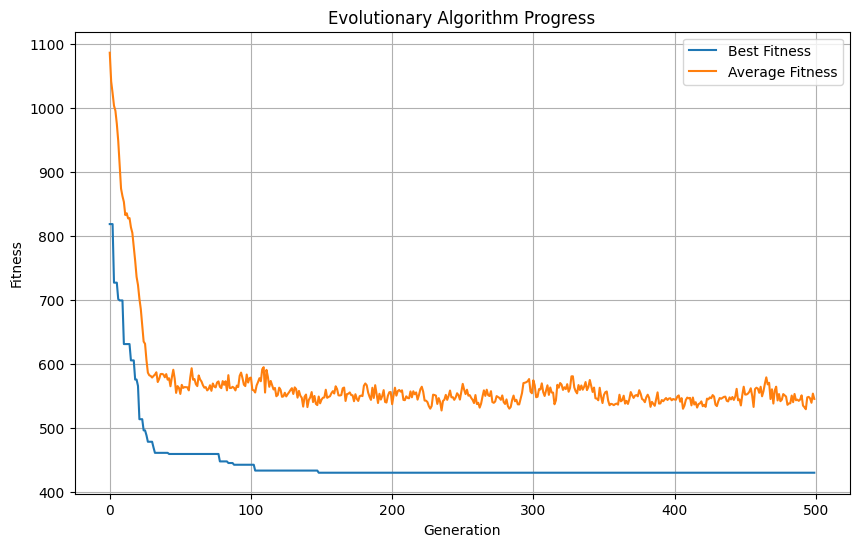

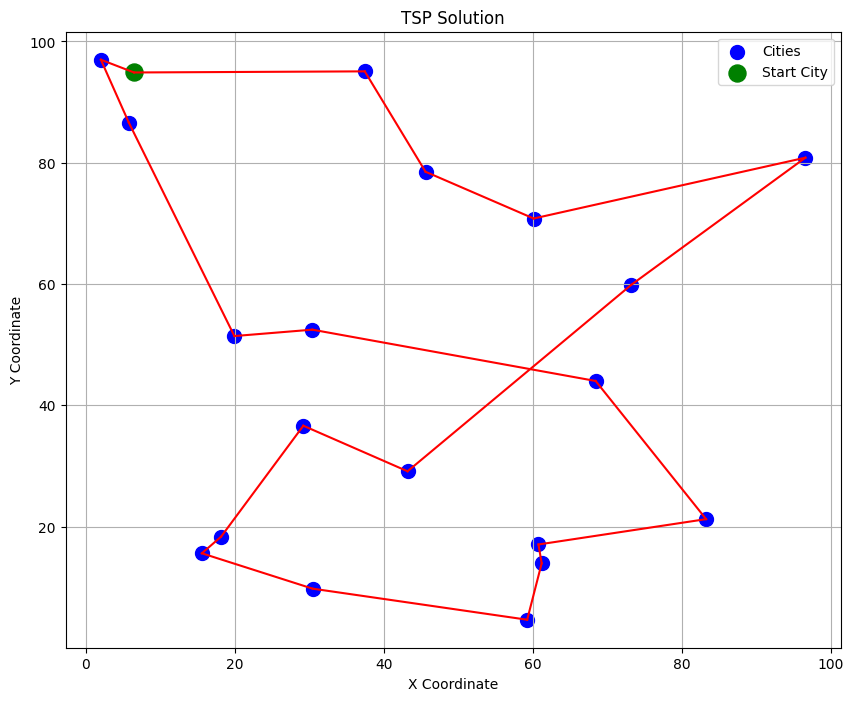


Portfolio Optimization:
Best weights: [0.        0.        0.        0.1613419 0.8386581]
Expected return: 10.68%
Risk (standard deviation): 0.09%
Sharpe ratio: 99.7095


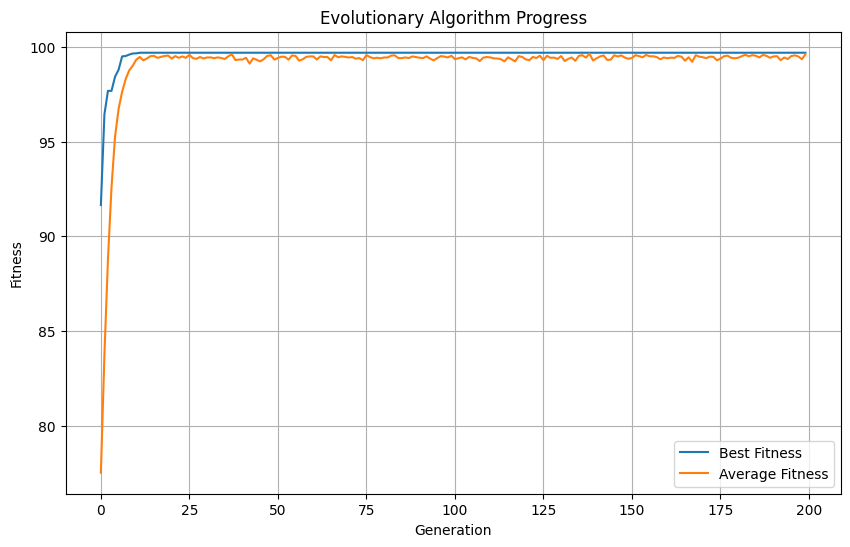

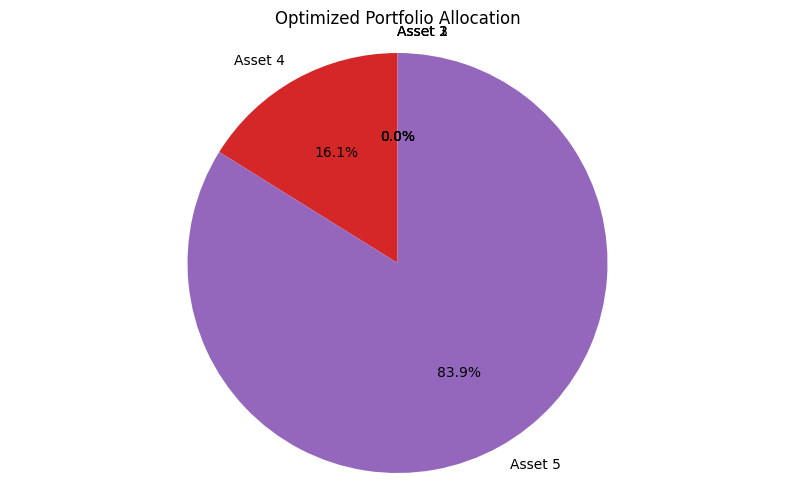

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple
import random

class EvolutionaryAlgorithm:
    """
    A generic evolutionary algorithm implementation for optimization problems.

    This implementation includes:
    - Population initialization
    - Selection (tournament selection)
    - Crossover (uniform crossover)
    - Mutation (Gaussian mutation)
    - Elitism

    The algorithm can be applied to minimize or maximize a fitness function.
    """

    def __init__(self,
                 fitness_function: Callable,
                 bounds: List[Tuple[float, float]],
                 population_size: int = 50,
                 generations: int = 100,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.1,
                 elitism: float = 0.1,
                 maximize: bool = False):
        """
        Initialize the evolutionary algorithm.

        Args:
            fitness_function: The objective function to optimize
            bounds: List of (min, max) bounds for each dimension
            population_size: Size of the population
            generations: Number of generations to run
            crossover_rate: Probability of crossover
            mutation_rate: Probability of mutation
            elitism: Percentage of best individuals to preserve
            maximize: If True, maximize the fitness function; if False, minimize
        """
        self.fitness_function = fitness_function
        self.bounds = bounds
        self.dimensions = len(bounds)
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.maximize = maximize

        # For tracking progress
        self.best_fitness_history = []
        self.avg_fitness_history = []
        self.best_individual = None
        self.best_fitness = float('-inf') if maximize else float('inf')

    def initialize_population(self) -> np.ndarray:
        """
        Initialize a random population within the specified bounds.

        Returns:
            np.ndarray: Initialized population
        """
        population = np.zeros((self.population_size, self.dimensions))
        for i in range(self.dimensions):
            min_val, max_val = self.bounds[i]
            population[:, i] = np.random.uniform(min_val, max_val, self.population_size)
        return population

    def evaluate_population(self, population: np.ndarray) -> np.ndarray:
        """
        Evaluate the fitness of each individual in the population.

        Args:
            population: The population to evaluate

        Returns:
            np.ndarray: Array of fitness values
        """
        fitness_values = np.zeros(self.population_size)
        for i in range(self.population_size):
            fitness_values[i] = self.fitness_function(population[i])
        return fitness_values

    def tournament_selection(self, population: np.ndarray, fitness_values: np.ndarray,
                            tournament_size: int = 3) -> np.ndarray:
        """
        Tournament selection to choose parents for reproduction.

        Args:
            population: Current population
            fitness_values: Fitness values for each individual
            tournament_size: Number of individuals in each tournament

        Returns:
            np.ndarray: Selected parents
        """
        selected = np.zeros_like(population)

        for i in range(self.population_size):
            # Randomly select individuals for the tournament
            tournament_indices = np.random.choice(self.population_size, tournament_size, replace=False)
            tournament_fitness = fitness_values[tournament_indices]

            # Find the best individual in the tournament
            if self.maximize:
                winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            else:
                winner_idx = tournament_indices[np.argmin(tournament_fitness)]

            selected[i] = population[winner_idx]

        return selected

    def uniform_crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Uniform crossover between two parents to create two offspring.

        Args:
            parent1: First parent
            parent2: Second parent

        Returns:
            Tuple[np.ndarray, np.ndarray]: Two offspring
        """
        if np.random.random() <= self.crossover_rate:
            # Create a random binary mask
            mask = np.random.random(self.dimensions) < 0.5

            # Create offspring by crossing over parents
            offspring1 = np.where(mask, parent1, parent2)
            offspring2 = np.where(mask, parent2, parent1)

            return offspring1, offspring2
        else:
            # Return exact copies of parents (no crossover)
            return parent1.copy(), parent2.copy()

    def gaussian_mutation(self, individual: np.ndarray) -> np.ndarray:
        """
        Apply Gaussian mutation to an individual.

        Args:
            individual: The individual to mutate

        Returns:
            np.ndarray: Mutated individual
        """
        mutated = individual.copy()

        for i in range(self.dimensions):
            # Apply mutation with given probability
            if np.random.random() <= self.mutation_rate:
                # Calculate mutation scale based on the bounds
                min_val, max_val = self.bounds[i]
                scale = 0.1 * (max_val - min_val)  # 10% of the range

                # Apply Gaussian mutation
                mutation = np.random.normal(0, scale)
                mutated[i] += mutation

                # Ensure the value remains within bounds
                mutated[i] = np.clip(mutated[i], min_val, max_val)

        return mutated

    def apply_elitism(self, population: np.ndarray, fitness_values: np.ndarray,
                     new_population: np.ndarray) -> np.ndarray:
        """
        Apply elitism by preserving the best individuals.

        Args:
            population: Current population
            fitness_values: Fitness values of current population
            new_population: Next generation population

        Returns:
            np.ndarray: New population with elites
        """
        # Number of elites to preserve
        num_elites = int(self.population_size * self.elitism)

        if num_elites > 0:
            # Sort individuals by fitness
            if self.maximize:
                elite_indices = np.argsort(fitness_values)[-num_elites:]
            else:
                elite_indices = np.argsort(fitness_values)[:num_elites]

            # Replace random individuals in the new population with elites
            replace_indices = np.random.choice(self.population_size, num_elites, replace=False)
            for i, idx in enumerate(replace_indices):
                new_population[idx] = population[elite_indices[i]]

        return new_population

    def evolve(self) -> Tuple[np.ndarray, float]:
        """
        Run the evolutionary algorithm.

        Returns:
            Tuple[np.ndarray, float]: Best individual and its fitness
        """
        # Initialize population
        population = self.initialize_population()

        # Main evolutionary loop
        for generation in range(self.generations):
            # Evaluate fitness
            fitness_values = self.evaluate_population(population)

            # Track best solution
            if self.maximize:
                max_fitness_idx = np.argmax(fitness_values)
                current_best_fitness = fitness_values[max_fitness_idx]
                if current_best_fitness > self.best_fitness:
                    self.best_fitness = current_best_fitness
                    self.best_individual = population[max_fitness_idx].copy()
            else:
                min_fitness_idx = np.argmin(fitness_values)
                current_best_fitness = fitness_values[min_fitness_idx]
                if current_best_fitness < self.best_fitness:
                    self.best_fitness = current_best_fitness
                    self.best_individual = population[min_fitness_idx].copy()

            # Track statistics
            self.best_fitness_history.append(self.best_fitness)
            self.avg_fitness_history.append(np.mean(fitness_values))

            # Selection
            selected = self.tournament_selection(population, fitness_values)

            # Create new population through crossover and mutation
            new_population = np.zeros_like(population)
            for i in range(0, self.population_size, 2):
                # Handle odd population size
                if i + 1 >= self.population_size:
                    new_population[i] = selected[i].copy()
                    continue

                # Select parents
                parent1 = selected[i]
                parent2 = selected[i + 1]

                # Crossover
                offspring1, offspring2 = self.uniform_crossover(parent1, parent2)

                # Mutation
                offspring1 = self.gaussian_mutation(offspring1)
                offspring2 = self.gaussian_mutation(offspring2)

                # Add to new population
                new_population[i] = offspring1
                new_population[i + 1] = offspring2

            # Apply elitism
            new_population = self.apply_elitism(population, fitness_values, new_population)

            # Update population
            population = new_population

        # Final evaluation
        final_fitness = self.evaluate_population(population)
        if self.maximize:
            best_idx = np.argmax(final_fitness)
            best_final_fitness = final_fitness[best_idx]
            best_final_individual = population[best_idx]
            if best_final_fitness > self.best_fitness:
                self.best_fitness = best_final_fitness
                self.best_individual = best_final_individual.copy()
        else:
            best_idx = np.argmin(final_fitness)
            best_final_fitness = final_fitness[best_idx]
            best_final_individual = population[best_idx]
            if best_final_fitness < self.best_fitness:
                self.best_fitness = best_final_fitness
                self.best_individual = best_final_individual.copy()

        return self.best_individual, self.best_fitness

    def plot_progress(self):
        """Plot the progress of the evolutionary algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_fitness_history, label='Best Fitness')
        plt.plot(self.avg_fitness_history, label='Average Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Evolutionary Algorithm Progress')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example 1: Optimizing a simple function
def example_function_minimization():
    """
    Example: Minimize the Rosenbrock function
    """
    def rosenbrock(x):
        """Rosenbrock function: f(x,y) = (1-x)^2 + 100(y-x^2)^2"""
        return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

    # Define bounds for (x, y)
    bounds = [(-2.0, 2.0), (-1.0, 3.0)]

    # Create and run evolutionary algorithm
    ea = EvolutionaryAlgorithm(
        fitness_function=rosenbrock,
        bounds=bounds,
        population_size=100,
        generations=200,
        crossover_rate=0.8,
        mutation_rate=0.1,
        elitism=0.1,
        maximize=False  # We want to minimize the function
    )

    best_solution, best_fitness = ea.evolve()

    print("Minimizing Rosenbrock Function:")
    print(f"Best solution found: {best_solution}")
    print(f"Fitness value: {best_fitness}")
    print(f"Expected optimum: [1.0, 1.0] with value 0.0")

    ea.plot_progress()

    # Visualize the function and solution
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-1, 3, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(len(x)):
        for j in range(len(y)):
            Z[j, i] = rosenbrock([X[j, i], Y[j, i]])

    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, np.log(Z + 1), 50, cmap='viridis')
    plt.colorbar(cp, label='log(f(x,y) + 1)')
    plt.plot(best_solution[0], best_solution[1], 'r*', markersize=10, label='Best solution found')
    plt.plot(1.0, 1.0, 'go', markersize=10, label='Global optimum')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Rosenbrock Function Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example 2: Traveling Salesman Problem (TSP)
def example_tsp():
    """
    Example: Solving the Traveling Salesman Problem
    """
    # Generate random cities
    np.random.seed(42)
    num_cities = 20
    cities = np.random.rand(num_cities, 2) * 100  # Cities in a 100x100 grid

    # Calculate distance matrix
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i, j] = np.sqrt(((cities[i] - cities[j])**2).sum())

    # Custom fitness function for TSP
    def tsp_fitness(route):
        """
        Calculate the total distance of a route.
        The route is represented as a continuous array, which we convert to indices.
        """
        # Convert continuous values to indices
        indices = np.argsort(route)

        # Calculate total distance
        total_distance = 0
        for i in range(num_cities):
            from_city = indices[i]
            to_city = indices[(i + 1) % num_cities]  # Return to the start
            total_distance += distance_matrix[from_city, to_city]

        return total_distance

    # Define bounds (for continuous representation)
    bounds = [(0, 1)] * num_cities

    # Create and run evolutionary algorithm
    ea = EvolutionaryAlgorithm(
        fitness_function=tsp_fitness,
        bounds=bounds,
        population_size=100,
        generations=500,
        crossover_rate=0.8,
        mutation_rate=0.2,
        elitism=0.1,
        maximize=False  # We want to minimize the distance
    )

    best_solution, best_fitness = ea.evolve()

    # Convert best solution to route
    best_route = np.argsort(best_solution)

    print("\nTraveling Salesman Problem:")
    print(f"Best route found: {best_route}")
    print(f"Total distance: {best_fitness}")

    ea.plot_progress()

    # Visualize the best route
    plt.figure(figsize=(10, 8))
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100, label='Cities')

    # Connect cities in the route
    for i in range(num_cities):
        from_city = best_route[i]
        to_city = best_route[(i + 1) % num_cities]
        plt.plot([cities[from_city, 0], cities[to_city, 0]],
                [cities[from_city, 1], cities[to_city, 1]], 'r-')

    # Highlight start city
    plt.scatter(cities[best_route[0], 0], cities[best_route[0], 1],
               c='green', s=150, label='Start City')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('TSP Solution')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example 3: Portfolio Optimization
def example_portfolio_optimization():
    """
    Example: Portfolio optimization to maximize returns while minimizing risk
    """
    # Sample data: expected returns and covariance matrix for 5 assets
    np.random.seed(42)
    num_assets = 5

    # Expected annual returns for each asset (%)
    expected_returns = np.array([10.0, 12.0, 8.0, 9.0, 11.0])

    # Covariance matrix (risk)
    # Generate a random positive definite matrix for demonstration
    A = np.random.rand(num_assets, num_assets)
    cov_matrix = np.dot(A, A.transpose()) / 100  # Scale down to get realistic values

    def portfolio_fitness(weights):
        """
        Calculate the Sharpe ratio (return-to-risk ratio)
        We'll maximize this value
        """
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)

        # Calculate expected return and risk
        expected_return = np.sum(weights * expected_returns)
        risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Risk-free rate (%)
        risk_free_rate = 2.0

        # Sharpe ratio (higher is better)
        sharpe_ratio = (expected_return - risk_free_rate) / risk

        return sharpe_ratio

    # Define bounds (weights between 0 and 1)
    bounds = [(0, 1)] * num_assets

    # Create and run evolutionary algorithm
    ea = EvolutionaryAlgorithm(
        fitness_function=portfolio_fitness,
        bounds=bounds,
        population_size=100,
        generations=200,
        crossover_rate=0.8,
        mutation_rate=0.1,
        elitism=0.1,
        maximize=True  # We want to maximize the Sharpe ratio
    )

    best_solution, best_fitness = ea.evolve()

    # Normalize weights
    best_weights = best_solution / np.sum(best_solution)

    # Calculate expected return and risk
    expected_return = np.sum(best_weights * expected_returns)
    risk = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix, best_weights)))

    print("\nPortfolio Optimization:")
    print(f"Best weights: {best_weights}")
    print(f"Expected return: {expected_return:.2f}%")
    print(f"Risk (standard deviation): {risk:.2f}%")
    print(f"Sharpe ratio: {best_fitness:.4f}")

    ea.plot_progress()

    # Visualize the portfolio allocation
    plt.figure(figsize=(10, 6))
    plt.pie(best_weights, labels=[f'Asset {i+1}' for i in range(num_assets)],
           autopct='%1.1f%%', startangle=90)
    plt.title('Optimized Portfolio Allocation')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()


if __name__ == "__main__":
    # Run the examples
    example_function_minimization()
    example_tsp()
    example_portfolio_optimization()